In [1]:
%pip install -U torchtext==0.6
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import string
import numpy as np
import re
from pickle import load,dump
from unicodedata import normalize
from numpy import array
from numpy.random import rand
from numpy.random import shuffle
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [2]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [3]:
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [45]:
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [5]:
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [46]:
# load dataset
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pair = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pair, 'english-german.pkl')

Saved: english-german.pkl


In [48]:
# load dataset for 5000 not used in training
filename = 'deu_5000.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pair = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pair, 'english-german_5000.pkl')

Saved: english-german_5000.pkl


In [7]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [26]:
# Vocabularul 
raw_dataset = load_clean_sentences('english-german.pkl')
# reduce dataset size
n_sentences = 30000
dataset = raw_dataset[:n_sentences, :]

In [27]:
# Shuffle dataset - DOAR O DATA!
# random shuffle
shuffle(dataset)

In [28]:
# Salvare dataset
save_clean_data(dataset, 'english-german-clean.pkl')

Saved: english-german-clean.pkl


In [30]:
# Preluare dataset

# load dataset
dataset = load_clean_sentences('english-german-clean.pkl')

In [31]:
# split into train/test
train, test = dataset[:27000], dataset[27001:n_sentences]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')


Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [32]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [33]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [34]:
def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [35]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [36]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1]) # germana
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0]) # engleza
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)
# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
#model.load_weights('model.h5')

English Vocabulary Size: 6679
English Max Length: 8
German Vocabulary Size: 11517
German Max Length: 17


In [13]:

model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=35, batch_size=128, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 5049
English Max Length: 7
German Vocabulary Size: 8284
German Max Length: 11


KeyboardInterrupt: 

In [37]:
# Load model from model.h5

# load datasets
model = load_model('model_cluster.h5')




In [38]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [39]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [67]:
def evaluate_model(model, eng_tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [68]:
#print('train')
#evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

test
src=[alle deine katzen sind grau], target=[all of your cats are grey], predicted=[all of are cats are grey]
src=[tom wird mary die entscheidung treffen lassen], target=[tom will let mary decide], predicted=[tom will see mary decide]
src=[kennst du tom personlich], target=[do you know tom personally], predicted=[do you know tom personally]
src=[er ware beinahe gestorben], target=[he almost died], predicted=[he almost laughed]
src=[ich habe halsschmerzen], target=[i have a sore throat], predicted=[i have a sore throat]
src=[tom ist alter als maria], target=[tom is older than mary], predicted=[tom is older than mary]
src=[bitte werfen sie eine munze ein], target=[please insert a coin], predicted=[please insert a coin]
src=[tom hort zu], target=[tom listens], predicted=[tom listens]
src=[er ist ein schneller laufer], target=[he runs fast], predicted=[he is an fast]
src=[ich dachte du warest glucklich], target=[i thought you were happy], predicted=[i thought you were happy]
BLEU-1: 0.8

In [1]:
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)

train


NameError: name 'evaluate_model' is not defined

In [40]:
# Functia de traducere
def translate(text):
    text_to_translate = [text]

    sequences = ger_tokenizer.texts_to_sequences(text_to_translate)
    sequences = pad_sequences(sequences, maxlen=ger_length, padding='post')

    translation = predict_sequence(model, eng_tokenizer, sequences)
    return translation


In [41]:
source = "Ich bin h# eute schlechter Laune."
target = "I'm in a bad mood today."

output = translate(source)

# BLEU
bleu = corpus_bleu([target], [output], weights=(1.0, 0, 0, 0))
print(bleu)

0.4


C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-pa

In [19]:

source = "Es ist immer noch Montag."
target = "It's still Monday."

output = translate(source)
print(output)

# BLEU
bleu = corpus_bleu([target], [output], weights=(1.0, 0, 0, 0))
print(bleu)

its is over
0.45454545454545453


C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-pa

In [49]:

# Avem modelul antrenat de Alice.
# Luam o parte din datasetul pe care s-a antrenat modelul si il testam cu acesta => label IN probe
# Luam o alta parte din dataset pe care modelul lui Alice NU s-a antrenat si il testam si pe acesta => label OUT probe
# Construim un clasificator care, pe baza scorurilor generate pe fiecare label, acesta poate eticheta daca o propozitie
# este IN probe sau OUT probe
# Pentru testarea clasificatorului, se aleg alte bucati din dataset care sunt atat IN probe si OUT probe si se verifica
# acuratetea ghicelii. Daca per total avem rezultat de 50% sau mai putin => ESEC , altfel, atacul este un success


raw_dataset = load_clean_sentences('english-german-clean.pkl')
shuffle(raw_dataset)
dimension_to_split =  20000 #14000
#max_dim = 100000
# reduce dataset size
n_sentences_limit = 5000 #5000
dataset = raw_dataset[:dimension_to_split, :]
# random shuffle
shuffle(dataset)

dataset_trained = dataset[:n_sentences_limit, :]

# make dataset_trained an array where first 3 columns are arrays and 4th column is a number
#dataset_trained = np.array(dataset_trained)
#dataset_trained = np.reshape(dataset_trained, (len(dataset_trained), 4))


column_pahar = []
new_dataset_trained = []
for sentence in dataset_trained:
    sentence = np.append(sentence, translate(sentence[1]))
    sentence = np.append(sentence, 1) # IN
    column_pahar = sentence[0]
    sentence[0] = sentence[1]
    sentence[1] = column_pahar
    bleu = corpus_bleu([sentence[1]], [sentence[2]], weights=(1.0, 0, 0, 0))
    sentence = np.append(sentence, bleu)
    new_dataset_trained.append(sentence)

dataset_5000 = load_doc('deu_5000.txt')

dataset_5000 = to_pairs(dataset_5000)

dataset_5000 = clean_pairs(dataset_5000)

save_clean_data = (dataset_5000, 'english-german_5000.pkl')

dataset_5000 = np.array(dataset_5000)

dataset_2 = dataset_5000
#raw_dataset[dimension_to_split:max_dim, :]
# random shuffle
shuffle(dataset_2)
dataset_not_trained = dataset_2[:n_sentences_limit, :]

new_dataset_untrained = []
for sentence in dataset_not_trained:
    sentence = np.append(sentence, translate(sentence[1]))
    sentence = np.append(sentence, 0) # OUT
    column_pahar = sentence[0]
    sentence[0] = sentence[1]
    sentence[1] = column_pahar
    bleu = corpus_bleu([sentence[1]], [sentence[2]], weights=(1.0, 0, 0, 0))
    sentence = np.append(sentence, bleu)
    new_dataset_untrained.append(sentence)

# big_list = [dataset_trained, dataset_not_trained]
big_list = new_dataset_trained + new_dataset_untrained
shuffle(big_list)
# df = pd.DataFrame(dataset_trained, dataset_not_trained, )


# We luam 5000 de propozitii din A_train (folosite de Alice la training)
# Luam 5000 propozitii nefolosite in training si alcatuim un tabel de forma
# PROP_GERMANA  OUTPUT  TARGET  LABEL

# PROP_GERMANA = propozitia in germana
# OUTPUT = propozitia in engleza generata de Alice
# TARGET = propozitia in engleza corecta
# LABEL = IN sau OUT



C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-pa

In [50]:
import pandas as pd 
# print (new_dataset_trained)
df = pd.DataFrame(big_list, columns=['INPUT', 'REF', 'OUTPUT', 'LABEL', 'BLEU'])

In [51]:
filename = 'dataset.csv'
df.to_csv(filename, sep=',', index=False, encoding='utf-8')

In [52]:
print(df)

                                      INPUT                        REF  \
0             wozu wollt ihr das denn haben  what do you want that for   
1         das hort sich fur mich komisch an  that sounds strange to me   
2                  das streite ich nicht ab        im not denying that   
3            auf der toilette nicht rauchen   dont smoke in the toilet   
4                             was sagen sie       what are they saying   
...                                     ...                        ...   
9995                     er offnete die tur         he opened the door   
9996                        er sagte nichts            he said nothing   
9997  wie wird es mit japan nur weitergehen  what will become of japan   
9998                ich habe alles verloren          i lost everything   
9999              nehmen sie ihre tabletten            take your pills   

                          OUTPUT LABEL                 BLEU  
0            what do you want to     1   0.526315

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [54]:
train_limit = int(8 / 10 * 2 * n_sentences_limit)

In [55]:
# df - dataset, split between training and testing
# NAIVE BAYES

df_train = df[:train_limit]
df_test = df[train_limit+1:]

X_train = df_train['BLEU']
y_train = df_train['LABEL']


# Train the classifier
classifier = MultinomialNB()
classifier.fit(X_train.values.reshape(-1, 1), y_train)
classifier.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = classifier.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)
print("Classification Report:")
print(report)


Accuracy: 0.4897448724362181
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1020
           1       0.49      1.00      0.66       979

    accuracy                           0.49      1999
   macro avg       0.24      0.50      0.33      1999
weighted avg       0.24      0.49      0.32      1999



C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

Naive Bayes


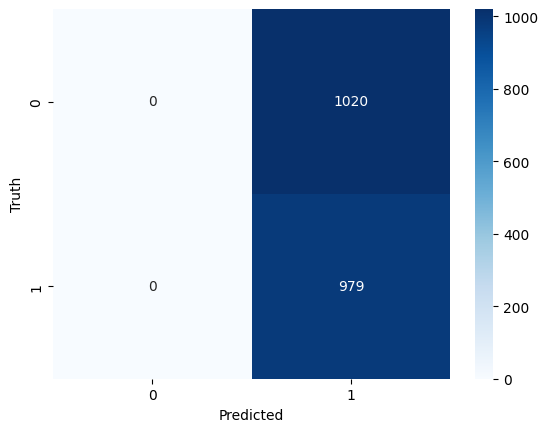

In [56]:
# Confussion matrix
# Naive Bayes
print("Naive Bayes")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [57]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X_train = df_train['BLEU']
y_train = df_train['LABEL']

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = clf.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)

print("Classification Report:")
print(report)


Accuracy: 0.583791895947974
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.39      0.49      1020
           1       0.55      0.78      0.65       979

    accuracy                           0.58      1999
   macro avg       0.60      0.59      0.57      1999
weighted avg       0.60      0.58      0.57      1999



Random Forest


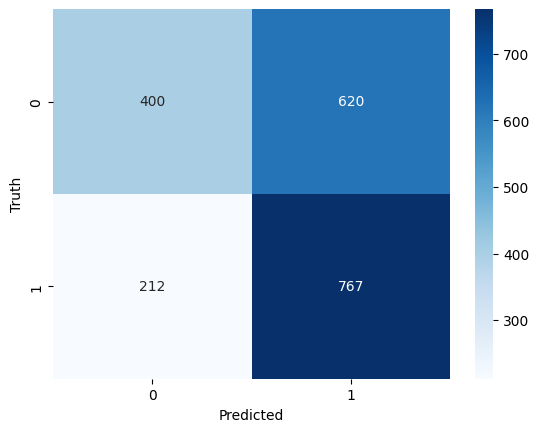

In [58]:
# Confussion matrix

# Random Forest
print("Random Forest")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [59]:
# NEAREST NEIGHBOUR
from sklearn.neighbors import KNeighborsClassifier

X_train = df_train['BLEU']
y_train = df_train['LABEL']

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data

y_pred = neigh.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)

print("Classification Report:")
print(report)

Accuracy: 0.5532766383191596
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.52      0.54      1020
           1       0.54      0.59      0.57       979

    accuracy                           0.55      1999
   macro avg       0.55      0.55      0.55      1999
weighted avg       0.55      0.55      0.55      1999



Nearest Neighbour


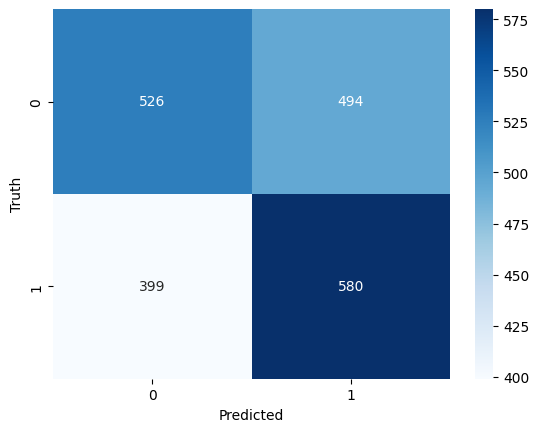

In [60]:
# Nearest Neighbour
print("Nearest Neighbour")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [61]:
# Perceptron

from sklearn.linear_model import Perceptron

X_train = df_train['BLEU']
y_train = df_train['LABEL']

clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = clf.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)

print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)

print("Classification Report:")
print(report)


Accuracy: 0.5102551275637819
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      1020
           1       0.00      0.00      0.00       979

    accuracy                           0.51      1999
   macro avg       0.26      0.50      0.34      1999
weighted avg       0.26      0.51      0.34      1999



C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

Perceptron


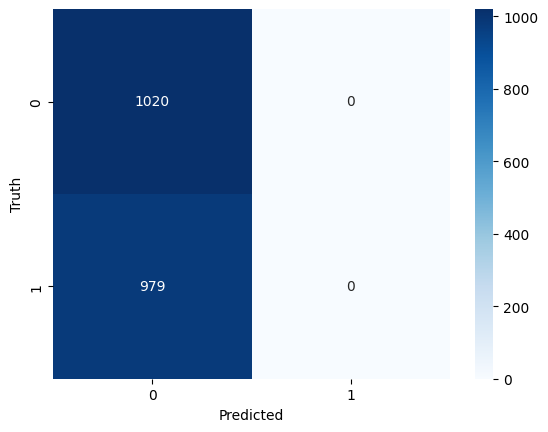

In [62]:
# Perceptron
print("Perceptron")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [63]:
# Multi-layer Perceptron (MLP)

from sklearn.neural_network import MLPClassifier

X_train = df_train['BLEU']
y_train = df_train['LABEL']

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = clf.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)

print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)

print("Classification Report:")
print(report)




Accuracy: 0.5782891445722862
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.41      0.50      1020
           1       0.55      0.75      0.64       979

    accuracy                           0.58      1999
   macro avg       0.59      0.58      0.57      1999
weighted avg       0.59      0.58      0.57      1999



MLP


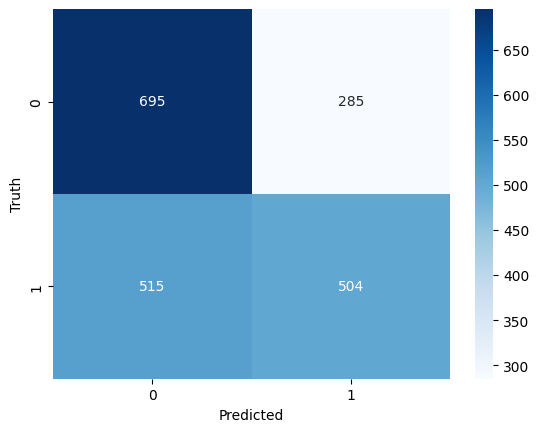

In [56]:
# MLP
print("MLP")
cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [64]:
# Decision Tree

from sklearn import tree

X_train = df_train['BLEU']
y_train = df_train['LABEL']

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train.values.reshape(-1, 1), y_train)

# Predict the labels for the testing data
y_pred = clf.predict(df_test['BLEU'].values.reshape(-1, 1))

# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test['LABEL'], y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(df_test['LABEL'], y_pred)
print("Classification Report:")
print(report)



Accuracy: 0.6198099049524762
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1020
           1       0.61      0.63      0.62       979

    accuracy                           0.62      1999
   macro avg       0.62      0.62      0.62      1999
weighted avg       0.62      0.62      0.62      1999



Decision Tree


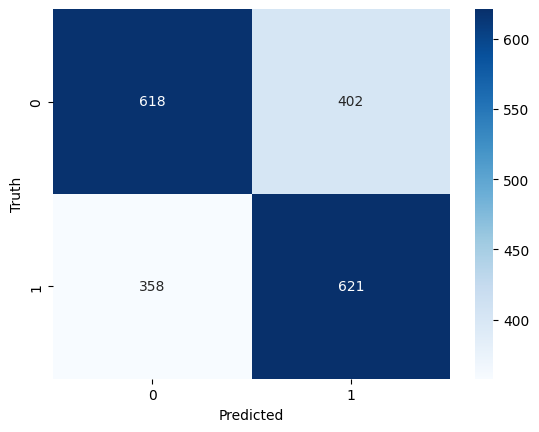

In [65]:
# Decision Tree

print("Decision Tree")

cm = confusion_matrix(df_test['LABEL'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()